# Analyse des types de SST et clustering (réseau complet)

**Objectif :** Analyser les différents types de sous-stations (SST) du réseau en incluant **toutes** les SST (archivées et non archivées). L'**archivage des données** est une dimension importante utilisée pour le clustering.

**Différence avec `analyse_arch_sst_clustering.ipynb` :**
- Ce notebook inclut les SST **sans** mesures archivées (présentes dans le CAD mais absentes du parquet)
- La variable **`archivé`** (0/1) est une feature de clustering

**Données sources :**
- **CAD** : `0_Data/0_Raw/RefFiles/Point_transmission_CAD_20260202.xlsx`
- **Mesures archivées** : `0_Data/1_Structured/sst_unified.parquet`

**Colonnes analysées :**
- `U_TYPE_REGUL`, `U_PROD_ECS`, `U_PUISSANCE`, **`archivé`**

In [5]:
# %% Imports et configuration
import re
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

PATH_CAD = Path("0_Data/0_Raw/RefFiles/Point_transmission_CAD_20260202.xlsx")
PATH_PARQUET = Path("0_Data/1_Structured/sst_unified.parquet")

try:
    plt.style.use("seaborn-v0_8-whitegrid")
except OSError:
    plt.style.use("seaborn-whitegrid")
sns.set_palette("husl")

## 1. Chargement des données

- Charger **toutes** les SST du CAD
- Extraire les EGIDs du parquet (SST avec mesures archivées)
- Créer la colonne **`archivé`** : 1 si SST dans le parquet, 0 sinon

In [6]:
# %% Chargement CAD (toutes les SST)
df_cad = pd.read_excel(PATH_CAD, sheet_name=0)
print(f"CAD : {len(df_cad)} sous-stations, {len(df_cad.columns)} colonnes")
df_cad.head(3)

CAD : 1245 sous-stations, 83 colonnes


,OBJECTID,NAME_NUMMER,ART,LEISTUNG_ABONNIERT,LEISTUNG_INSTALLIERT,BLENDENWERT,Q_ABONNIERT,KATEGORIE,DRUCK,VORLAUFTEMPERATUR,...,GN_CREATED_DATE,GN_CREATED_USER,GN_LAST_EDITED_DATE,GN_LAST_EDITED_USER,INBETRIEBSETZUNG,UMBAU,BAUJAHR,ILI_OPERAT,ILI_CLASS,ILI_XTF_ID
0,1,945073,Station de branchement d'immeuble,NaN,NaN,1.0,0.201,En service,NaN,95.0,...,16.07.2009,LIDS,27.01.2025 14:33,SEGUILBA,NaN,NaN,2009,NaN,NaN,NaN
1,2,945057,Station de branchement d'immeuble,NaN,NaN,1.0,0.201,En service,NaN,95.0,...,16.07.2009,LIDS,14.03.2022 13:45,MPGROSSR,NaN,NaN,2009,NaN,NaN,NaN
2,5,945069,Station de branchement d'immeuble,NaN,NaN,1.0,0.201,En service,NaN,95.0,...,16.07.2009,LIDS,13.03.2025 14:37,SEGUILBA,NaN,NaN,2009,NaN,NaN,NaN


In [7]:
# %% Extraction des EGIDs du parquet + création de df_sst (toutes les SST avec colonne archivé)
df_parquet = pd.read_parquet(PATH_PARQUET)
cols_measures = [c for c in df_parquet.columns if c not in ["timestamp_loc", "temp_ext_api"]]

egids_parquet = set()
for col in cols_measures:
    parts = col.split("_")
    if len(parts) >= 2 and parts[0].isdigit():
        egids_parquet.add(int(parts[0]))

df_cad["U_NO_EGID_num"] = pd.to_numeric(df_cad["U_NO_EGID"], errors="coerce")
df_sst = df_cad[df_cad["U_NO_EGID_num"].notna()].copy()
df_sst["U_NO_EGID_num"] = df_sst["U_NO_EGID_num"].astype(int)
df_sst["archivé"] = df_sst["U_NO_EGID_num"].isin(egids_parquet).astype(int)
df_sst = df_sst.drop(columns=["U_NO_EGID_num"])

n_arch = df_sst["archivé"].sum()
n_non_arch = len(df_sst) - n_arch
print(f"Parquet : {len(egids_parquet)} SST avec mesures archivées")
print(f"SST analysées : {len(df_sst)} (archivées : {n_arch}, non archivées : {n_non_arch})")
df_sst[["U_NO_EGID", "U_TYPE_REGUL", "U_PROD_ECS", "U_PUISSANCE", "archivé"]].head(10)

Parquet : 369 SST avec mesures archivées
SST analysées : 1238 (archivées : 369, non archivées : 869)


,U_NO_EGID,U_TYPE_REGUL,U_PROD_ECS,U_PUISSANCE,archivé
0,190507988,RVD 230-250,NaN,7kW,0
1,235557415,RVD 230-250,NaN,7kW,0
2,190210251,RVD 230-250,NaN,7kW,0
3,235557377,RVD 230-250,NaN,8kW,0
4,3091203,MR08/12,NaN,180kW,0
5,1511281,MR08/12,NaN,70kW,0
6,235556801,RVD 230-250,NaN,8kW,0
7,1511243,MR08/12,NaN,45kW,0
8,1511242,MR08/12,NaN,40kW,0
9,1511427,RVD 230-250,NaN,170kW,0


In [8]:
# Vérification : df_sst créé dans la cellule précédente
assert "df_sst" in dir(), "Exécuter d'abord la cellule 4 (Extraction EGIDs + Fusion)"
print("df_sst prêt :", len(df_sst), "SST")

df_sst prêt : 1238 SST


## 2. Analyse exploratoire

### 2.1 Répartition archivé / non archivé

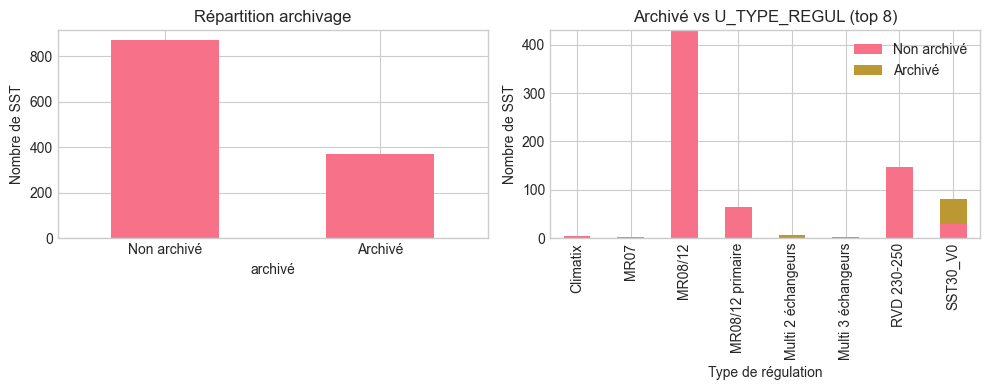

In [9]:
# %% Répartition archivé
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df_sst["archivé"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_xticklabels(["Non archivé", "Archivé"], rotation=0)
axes[0].set_ylabel("Nombre de SST")
axes[0].set_title("Répartition archivage")

pd.crosstab(df_sst["archivé"], df_sst["U_TYPE_REGUL"].fillna("_MANQUANT_")).iloc[:, :8].T.plot(kind="bar", stacked=True, ax=axes[1], legend=True)
axes[1].set_xlabel("Type de régulation")
axes[1].set_ylabel("Nombre de SST")
axes[1].set_title("Archivé vs U_TYPE_REGUL (top 8)")
axes[1].legend(["Non archivé", "Archivé"])
plt.tight_layout()
plt.show()

### 2.2 U_TYPE_REGUL, U_PROD_ECS, U_PUISSANCE

In [10]:
# %% Parsing U_PUISSANCE
def parse_puissance(s):
    if pd.isna(s): return np.nan
    m = re.search(r"([\d.]+)\s*k?W", str(s), re.I)
    return float(m.group(1)) if m else np.nan

df_sst["U_PUISSANCE_kW"] = df_sst["U_PUISSANCE"].apply(parse_puissance)
print("Statistiques U_PUISSANCE (kW) :")
print(df_sst["U_PUISSANCE_kW"].describe())
print(f"\nArchivé vs non archivé - médiane puissance :")
print(df_sst.groupby("archivé")["U_PUISSANCE_kW"].median())

Statistiques U_PUISSANCE (kW) :
count    1238.000000
mean       67.882876
std       114.203537
min         5.000000
25%        15.000000
50%        40.000000
75%        85.000000
max      2500.000000
Name: U_PUISSANCE_kW, dtype: float64

Archivé vs non archivé - médiane puissance :
archivé
0    40.0
1    40.0
Name: U_PUISSANCE_kW, dtype: float64


## 3. Préparation des features pour le clustering

**Features :** U_TYPE_REGUL, U_PROD_ECS, U_PUISSANCE, **archivé** (dimension importante)

In [11]:
# %% Préparation du DataFrame de clustering
df_cluster = df_sst[["U_NO_EGID", "U_TYPE_REGUL", "U_PROD_ECS", "U_PUISSANCE_kW", "archivé"]].copy()

df_cluster["U_TYPE_REGUL"] = df_cluster["U_TYPE_REGUL"].fillna("_MANQUANT_")
df_cluster["U_PROD_ECS"] = df_cluster["U_PROD_ECS"].fillna(-1).astype(str)

le_regul = LabelEncoder()
df_cluster["U_TYPE_REGUL_enc"] = le_regul.fit_transform(df_cluster["U_TYPE_REGUL"].astype(str))

def map_ecs(x):
    s = str(x).strip()
    if s in ("0", "0.0"): return 0
    if s in ("1", "1.0"): return 1
    return -1
df_cluster["U_PROD_ECS_enc"] = df_cluster["U_PROD_ECS"].apply(map_ecs)

med_puissance = df_cluster["U_PUISSANCE_kW"].median()
df_cluster["U_PUISSANCE_kW_fill"] = df_cluster["U_PUISSANCE_kW"].fillna(med_puissance)

# archivé reste 0 ou 1 - dimension importante pour le clustering
features = ["U_TYPE_REGUL_enc", "U_PROD_ECS_enc", "U_PUISSANCE_kW_fill", "archivé"]
X = df_cluster[features].values

# Poids optionnel : renforcer l'impact de archivé (ex. x2)
WEIGHT_ARCHIVE = 2.0  # Modifier pour augmenter/diminuer l'importance de l'archivage
X[:, 3] = X[:, 3] * WEIGHT_ARCHIVE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features :", features)
print("Poids archivé :", WEIGHT_ARCHIVE)
print("Shape :", X_scaled.shape)

Features : ['U_TYPE_REGUL_enc', 'U_PROD_ECS_enc', 'U_PUISSANCE_kW_fill', 'archivé']
Poids archivé : 2.0
Shape : (1238, 4)


## 4. Clustering KMeans

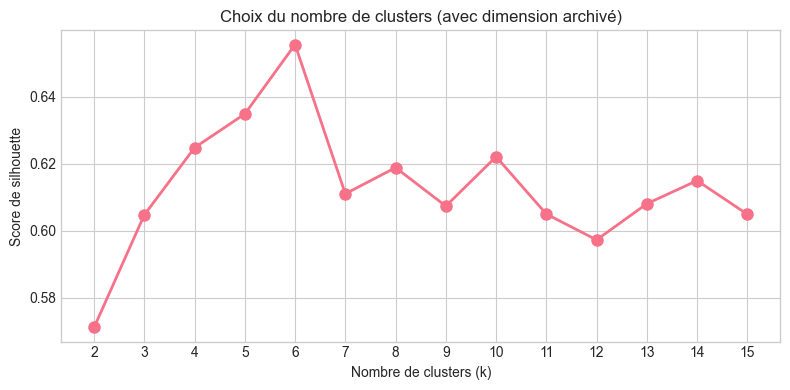

Meilleur k : 6


In [12]:
# %% Choix du nombre de clusters
k_range = range(2, 16)
silhouette_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(k_range), silhouette_scores, "o-", linewidth=2, markersize=8)
ax.set_xlabel("Nombre de clusters (k)")
ax.set_ylabel("Score de silhouette")
ax.set_title("Choix du nombre de clusters (avec dimension archivé)")
ax.set_xticks(list(k_range))
plt.tight_layout()
plt.show()

best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"Meilleur k : {best_k}")

In [13]:
# %% Clustering final
n_clusters = best_k
km_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_cluster["cluster"] = km_final.fit_predict(X_scaled)

print(f"Répartition des {n_clusters} clusters :")
print(df_cluster["cluster"].value_counts().sort_index())
print("\nRépartition archivé par cluster :")
print(pd.crosstab(df_cluster["cluster"], df_cluster["archivé"], margins=True))

Répartition des 6 clusters :
cluster
0    632
1    333
2    216
3      2
4     27
5     28
Name: count, dtype: int64

Répartition archivé par cluster :
archivé    0    1   All
cluster                
0        632    0   632
1          0  333   333
2        216    0   216
3          1    1     2
4         16   11    27
5          4   24    28
All      869  369  1238


## 5. Analyse des clusters

Profil de chaque cluster : U_TYPE_REGUL, U_PROD_ECS, U_PUISSANCE, **archivé**

In [14]:
# %% Profil des clusters
for c in range(n_clusters):
    subset = df_cluster[df_cluster["cluster"] == c]
    pct_arch = subset["archivé"].mean() * 100
    print(f"\n--- Cluster {c} ({len(subset)} SST, {pct_arch:.0f}% archivées) ---")
    print("  U_TYPE_REGUL (top 3) :", subset["U_TYPE_REGUL"].value_counts().head(3).to_dict())
    print("  U_PROD_ECS :", subset["U_PROD_ECS"].value_counts().to_dict())
    print("  U_PUISSANCE_kW : min={:.0f}, max={:.0f}, médiane={:.0f}".format(
        subset["U_PUISSANCE_kW"].min(), subset["U_PUISSANCE_kW"].max(), subset["U_PUISSANCE_kW"].median()
    ))


--- Cluster 0 (632 SST, 0% archivées) ---
  U_TYPE_REGUL (top 3) : {'MR08/12': 420, 'RVD 230-250': 145, 'MR08/12 primaire': 61}
  U_PROD_ECS : {'-1.0': 627, '0.0': 5}
  U_PUISSANCE_kW : min=6, max=300, médiane=50

--- Cluster 1 (333 SST, 100% archivées) ---
  U_TYPE_REGUL (top 3) : {'SST30_V1': 245, 'SST30_V0': 48, 'SST30_V2': 27}
  U_PROD_ECS : {'1.0': 257, '0.0': 76}
  U_PUISSANCE_kW : min=6, max=250, médiane=40

--- Cluster 2 (216 SST, 0% archivées) ---
  U_TYPE_REGUL (top 3) : {'SST30_V1': 140, 'SST30_V0': 26, 'SST30_V2': 23}
  U_PROD_ECS : {'1.0': 169, '0.0': 47}
  U_PUISSANCE_kW : min=5, max=230, médiane=20

--- Cluster 3 (2 SST, 50% archivées) ---
  U_TYPE_REGUL (top 3) : {'Multi 3 échangeurs': 1, '_MANQUANT_': 1}
  U_PROD_ECS : {'0.0': 1, '-1.0': 1}
  U_PUISSANCE_kW : min=1400, max=2500, médiane=1950

--- Cluster 4 (27 SST, 41% archivées) ---
  U_TYPE_REGUL (top 3) : {'SST30_V0': 7, 'Multi 2 échangeurs': 5, 'MR08/12 primaire': 3}
  U_PROD_ECS : {'0.0': 16, '-1.0': 10, '1.0': 1

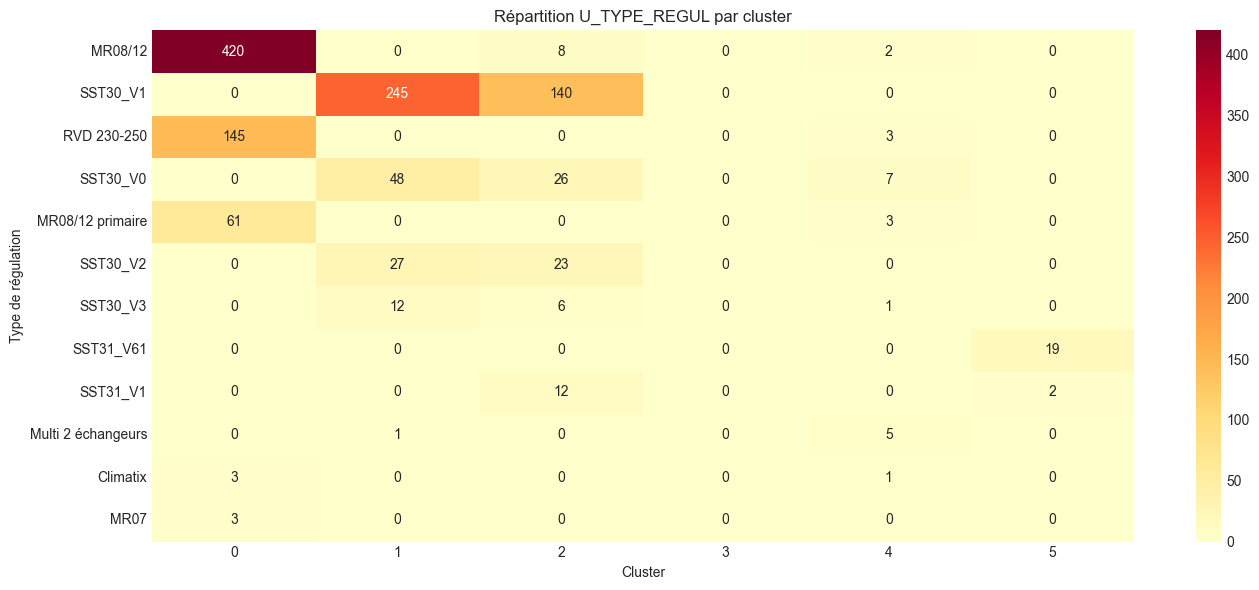

In [16]:
# %% Heatmap : répartition U_TYPE_REGUL par cluster
cross_regul = pd.crosstab(df_cluster["cluster"], df_cluster["U_TYPE_REGUL"])
top_types = [c for c in df_cluster["U_TYPE_REGUL"].value_counts().head(12).index if c in cross_regul.columns]
cross_regul_top = cross_regul[top_types] if top_types else cross_regul.iloc[:, :12]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(cross_regul_top.T, annot=True, fmt="d", cmap="YlOrRd", ax=ax)
ax.set_xlabel("Cluster")
ax.set_ylabel("Type de régulation")
ax.set_title("Répartition U_TYPE_REGUL par cluster")
plt.tight_layout()
plt.show()

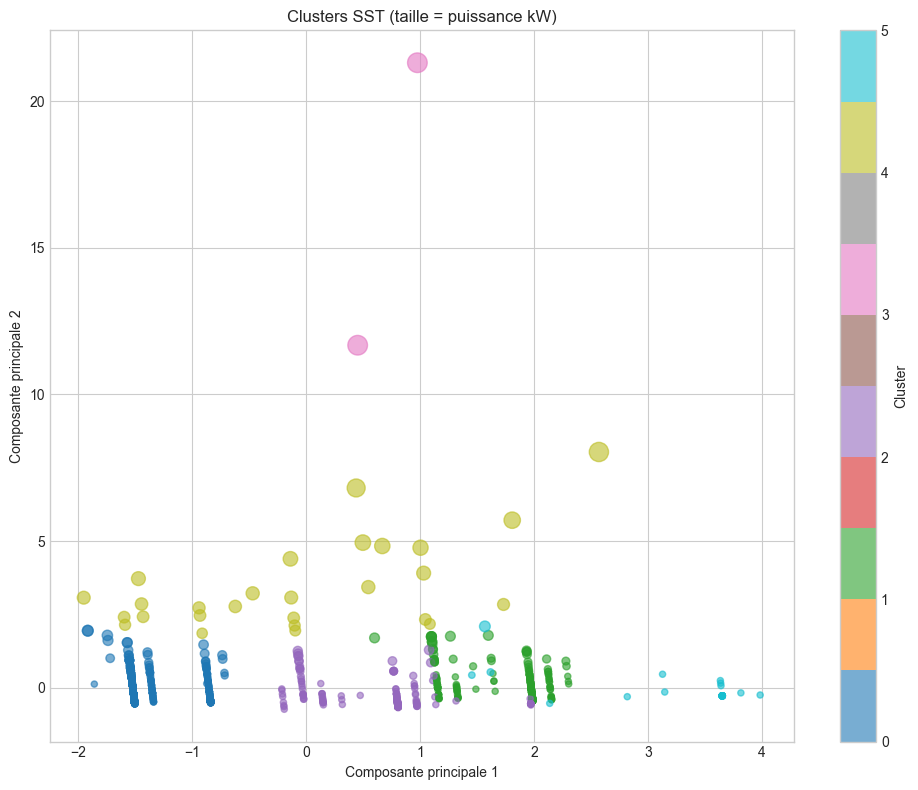

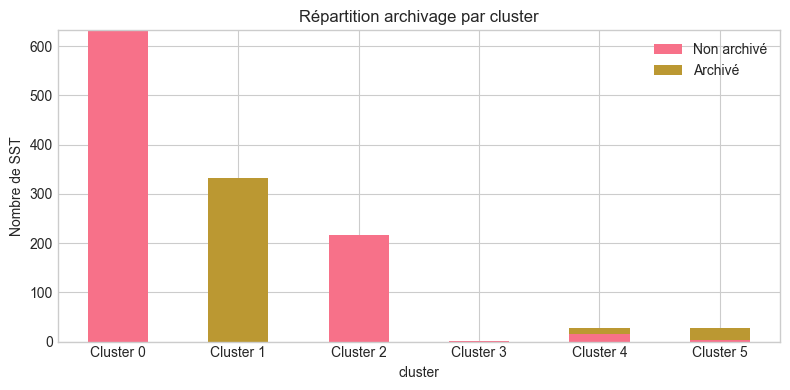

In [15]:
# %% Visualisation 2D (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_viz = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": df_cluster["cluster"],
    "archivé": df_cluster["archivé"],
    "U_PUISSANCE_kW": df_cluster["U_PUISSANCE_kW_fill"],
})

fig, ax = plt.subplots(figsize=(10, 8))
sizes = np.clip(df_viz["U_PUISSANCE_kW"] / 5, 20, 200)
scatter = ax.scatter(
    df_viz["PC1"], df_viz["PC2"],
    c=df_viz["cluster"], cmap="tab10", alpha=0.6, s=sizes
)
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_title("Clusters SST (taille = puissance kW)")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.tight_layout()
plt.show()

# Graphique archivé vs non archivé par cluster
fig, ax = plt.subplots(figsize=(8, 4))
pd.crosstab(df_cluster["cluster"], df_cluster["archivé"]).plot(kind="bar", ax=ax, stacked=True)
ax.set_xticklabels([f"Cluster {i}" for i in range(n_clusters)], rotation=0)
ax.set_ylabel("Nombre de SST")
ax.legend(["Non archivé", "Archivé"])
ax.set_title("Répartition archivage par cluster")
plt.tight_layout()
plt.show()

## 6. Export

In [ ]:
# %% Export
out_path = Path("0_Data/1_Structured/sst_avec_clusters_complet.parquet")
df_export = df_sst.merge(
    df_cluster[["U_NO_EGID", "cluster"]],
    on="U_NO_EGID",
    how="inner"
)
df_export.to_parquet(out_path, index=False)
print(f"Exporté : {out_path} ({len(df_export)} lignes)")
df_export[["U_NO_EGID", "U_TYPE_REGUL", "U_PROD_ECS", "U_PUISSANCE", "archivé", "cluster"]].head(10)